In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py as h5
import sys
from scipy.stats import binned_statistic
from scipy.stats import theilslopes
from importlib import reload
from pathlib import Path

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

import ana_fun as ana

#matplotlib.rcParams.keys()
matplotlib.rcParams['figure.figsize'] = (11, 7)
matplotlib.rc('font', size=14)
COLOR = 'grey'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

In [2]:
data = datastorage.read('vesp_run60_anaMPI.h5')
ttdata = datastorage.read('ttdata.h5')

t0 = 51.75
pixel_to_picosecond = 0.0033444

""" Mask nans and inf values """
mask = np.logical_and(~np.isnan(data.sig), ~np.isnan(data.I0))
mask &= ~np.isnan(ttdata['pix_edge_position'])
mask &= ~np.isinf(ttdata['pix_edge_error'])

mask &= ~np.logical_or(ttdata['pix_edge_error']>0.35, ttdata['pix_edge_error']<0) # warning for Nan values
mask &= ~np.logical_or(ttdata['pix_edge_position']>420, ttdata['pix_edge_position']<250) # warning for Nan values

dl = -((data.dl-t0)/0.15 + pixel_to_picosecond*ttdata['pix_edge_position'])
dl = dl[mask]
I0 = data.I0[mask]*1000
I = data.sig[mask]
energy = data.ebeam.photon_energy[mask]
energyL3 = data.ebeam.L3_energy[mask]

dl.shape

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


(222204,)

### Energy correction

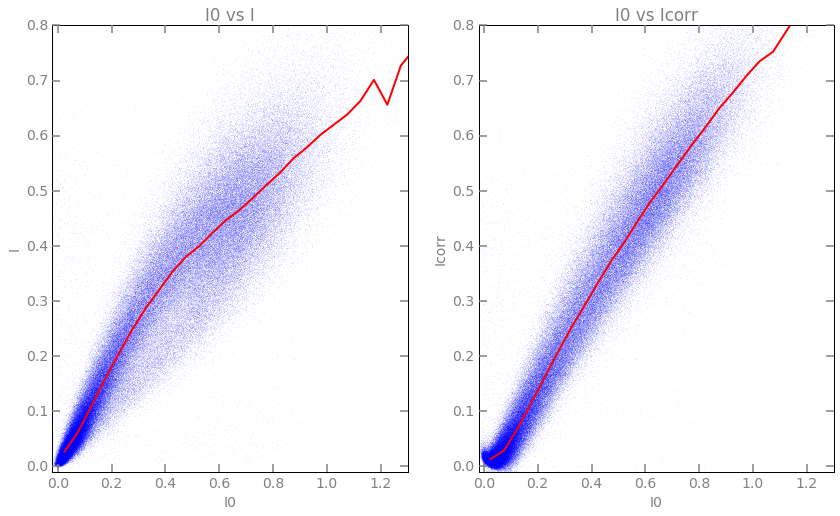

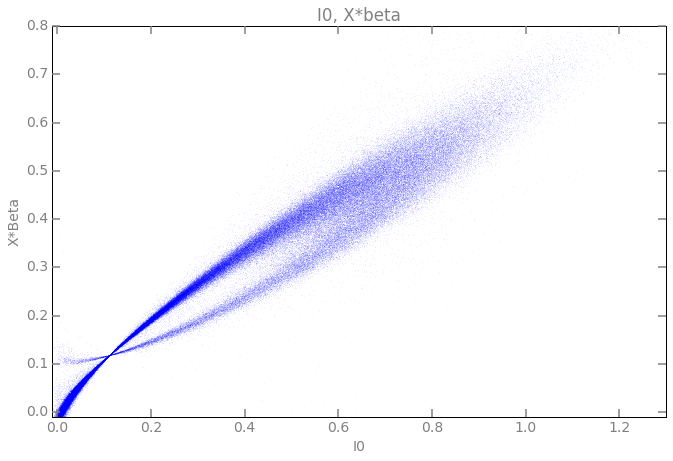

In [3]:
beta, Xbeta = ana.linearize_energy(I,I0,energy)
energy_I0_product = (energy-np.mean(energy))*(I0-np.mean(I0))
X = np.array([np.ones(len(I0)), I0, energy, energy_I0_product]).transpose()
Icorr = I - np.matmul(X[:,2:]-np.mean(X,axis=0)[2:], beta[2:])


""" Visualization """
plt.figure('I0 correlation: comparison', figsize=(14,8))
plt.subplot(1,2,2)
plt.plot(I0, Icorr, '.', markersize=0.08)
plt.title('I0 vs Icorr')
plt.xlabel('I0')
plt.ylabel('Icorr')

bins = np.arange(0,1.4,0.05)
med = binned_statistic(I0, Icorr, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2, color='red')
plt.xlim([-0.02,1.3])
plt.ylim([-0.01,0.8])

plt.subplot(1,2,1)
plt.plot(I0, I, '.', markersize=0.08)
plt.title('I0 vs I')
plt.xlabel('I0')
plt.ylabel('I')

med = binned_statistic(I0, I, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2, color='red')
plt.xlim([-0.02,1.3])
plt.ylim([-0.01,0.8])
plt.show()



plt.figure()
plt.title('I0, X*beta')
plt.plot(I0,Xbeta,'.',markersize=0.08)
plt.xlabel('I0')
plt.ylabel('X*Beta')
plt.xlim([-0.01,1.3])
plt.ylim([-0.01,0.8])
plt.show()

### Bin data and calculate slope

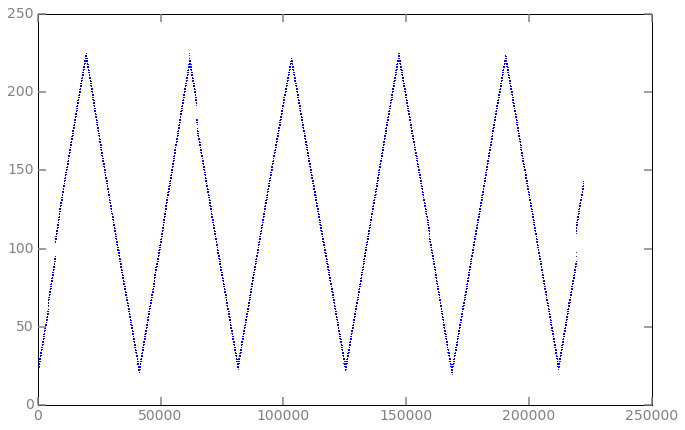

In [4]:
tbin_centers = np.arange(-5,20,0.1)
#tbin_centers = np.arange(-20,5,0.1)

""" Compute bin edges """
binDiff = np.diff(tbin_centers)
binDiff = np.append(binDiff, binDiff[-1])
binEdges = tbin_centers+binDiff/2
binEdges = np.append(binEdges[0]-binDiff[0], binEdges)

binIds = np.digitize(dl, binEdges)

plt.plot(binIds, '.', markersize=1)
plt.show()

In [15]:
def get_slope_bin(y,x,binIds,binNb):
    inBin = binIds == binNb
    xbin = x[inBin]
    ybin = y[inBin]
    dataPointNb = np.sum(inBin)
    if dataPointNb>1:
        theilslopes_res = theilslopes(ybin, xbin, alpha=0.95)
        theilslopes_err = 0.7*(theilslopes_res[3]-theilslopes_res[2])/2 # confidence interval is 3sigma
        return np.array([theilslopes_res[0], theilslopes_err, theilslopes_res[1], dataPointNb])
    else:
        return np.array([np.nan, np.nan, np.nan, dataPointNb])
    
t = np.asarray([tbin_centers[binNb] for binNb in np.unique(binIds)])
sig = np.asarray([get_slope_bin(I,I0,binIds,binNb) for binNb in np.unique(binIds)])

#for ii, binNb in enumerate(np.unique(binIds)):
#    inBin = shot_bin == binNb
#    string = str(ii) + ' , ' + str(np.sum(inBin))
#    #if np.sum(inBin)>1:
#   #    theilslopes_res = theilslopes(Icorr[inBin], I0[inBin], alpha=0.95)
#    test = get_slope_bin(I0, Icorr, binIds, binNb)
#   print(string)

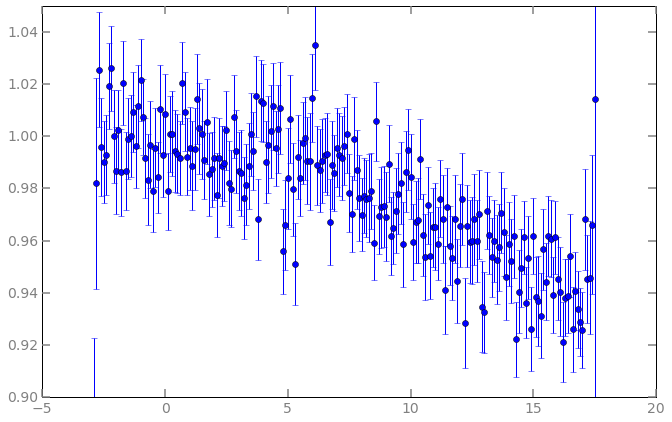

In [16]:
beforet0 = sig[t<0,0]
beforet0 = beforet0[~np.isnan(beforet0)][4:]

plt.figure('pump probe')
plt.errorbar(t, sig[:,0]/np.mean(beforet0), sig[:,1]/np.mean(beforet0), marker='o', linestyle='None')
plt.ylim(0.9,1.05)
plt.show()

### Bin data I/I0

Numbers of shots before I0 filtering: (222204,)
Numbers of shots after I0 filtering: (161305,)


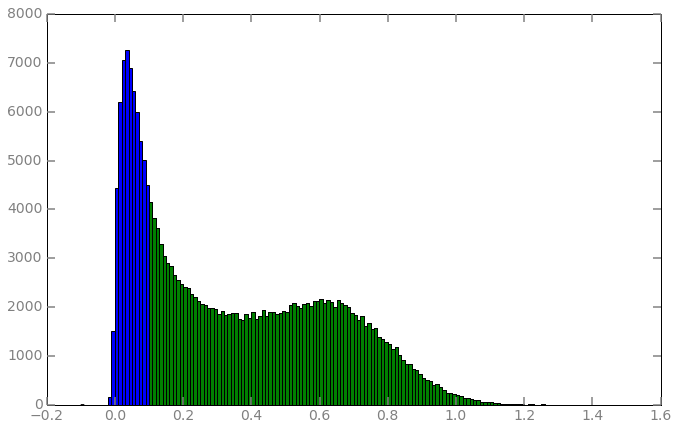

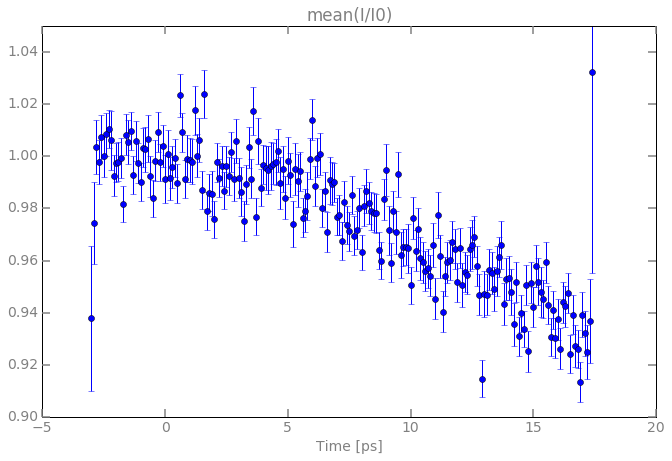

In [10]:
""" Filter I0 """
bins=np.arange(-0.1,1.5,0.01)
plt.hist(I0, bins=bins)
print('Numbers of shots before I0 filtering: {}'.format(I0.shape))

I0filt = 0.1
I0mask = I0>I0filt

dl_I0filt = dl[I0mask]
I0_I0filt = I0[I0mask]
I_I0filt = I[I0mask]
energy_I0filt = energy[I0mask]
energyL3_I0filt = energyL3[I0mask]
print('Numbers of shots after I0 filtering: {}'.format(I0_I0filt.shape))

plt.hist(I0_I0filt, bins=bins)
plt.show()


""" Bin data """
data_tobin = {
    'dl' : dl_I0filt,
    'I0' : I0_I0filt,
    'I' : I_I0filt,
    'Inorm' : I_I0filt/I0_I0filt,
    'energy' : energy_I0filt,
    'energyL3' : energyL3_I0filt
}

binned_data, bin_edges = ana.binData(data_tobin, bin_centers=tbin_centers, statkeys=['I0','I','Inorm'])


to_plot = 'Inorm'
beforet0 = binned_data[to_plot+'_mean'][binned_data['dl']<0]
beforet0 = beforet0[~np.isnan(beforet0)][4:]
plt.figure()
plt.errorbar(binned_data['dl'], 
             binned_data[to_plot+'_mean']/np.mean(beforet0), 
             binned_data[to_plot+'_std']/np.sqrt(binned_data[to_plot+'_count']), marker='o', linestyle='None')
plt.xlabel('Time [ps]')
plt.ylim([0.9,1.05])
plt.title('mean(I/I0)')
plt.show()